<div align="center">
    <h1>DS-210: Programming for Data Science</h1>
    <h1>Lecture 25</h1>
</div>

# 1. Representing graphs: examples in Rust
# 2. Sample graph algorithms
# 3. Modules

## Discussion section today

* Reading input from file
  * You'll be asked to do this on your homework
* Additional examples of using collections

# <font color="red">1. Representing graphs: examples in Rust</font>
# 2. Sample graph algorithms
# 3. Modules

## Sample graph

Sample graph from the previous lecture:

<div align="center">
    <img src="graph.svg" alt="[sample image]">
</div>

This lecture's graphs:
* undirected
* no self-loops
  * self-loop: edge connecting a vertex to itself
* no parallel edges (connecting the same pair of vertices)

Simplifying assumption:
* $n$ vertices labeled $0\ldots n-1$

## Adjacency list representation

<div align="center">
List of neighbors for each vertex
</div><br><br>

<img src="sparse.svg" alt="[adjacency lists]">


In [2]:
// number of vertices
let n : usize = 6;

// list of edges
let edges : Vec<(usize,usize)> = vec![(0,1), (0,2), (0,3), (1,2), (2,3), (2,4), (2,5)];
let mut graph_list : Vec<Vec<usize>> = vec![vec![];n];
for (v,w) in edges.iter() {
    graph_list[*v].push(*w);
    graph_list[*w].push(*v);
};
for i in 0..graph_list.len() {
    println!("{}: {:?}", i, graph_list[i]);
};

0: [1, 2, 3]
1: [0, 2]
2: [0, 1, 3, 4, 5]
3: [0, 2]
4: [2]
5: [2]


## Adjacency matrix representation

<div align="center">
Matrix of Boolean values
</div>

<br>
<img src="dense.svg" alt="[adjacency matrix]">

In [3]:
let mut graph_matrix = vec![vec![false;n];n];

In [4]:
for (v,w) in edges.iter() {
    graph_matrix[*v][*w] = true;
    graph_matrix[*w][*v] = true; 
};

In [5]:
for row in &graph_matrix {
    for entry in row.iter() {
        print!(" {} ",if *entry {"1"} else {"0"});
    }
    println!("");
};

 0  1  1  1  0  0 
 1  0  1  0  0  0 
 1  1  0  1  1  1 
 1  0  1  0  0  0 
 0  0  1  0  0  0 
 0  0  1  0  0  0 


## What if labels are not in $\{0,1,\ldots n-1\}$?
`T`${}={}$type of labels

**Solution 1:** Map everything to this range
  * Create hash maps from input labels to $\{0,1,\ldots n-1\}$
  * Create a reverse hash map to recover labels when needed

**Solution 2:** Replace with hash maps and hash sets
  * Adjacency lists: use `HashMap<T,Vec<T>>`
  * Adjacency matrix: use `HashSet<(T,T)>`


  * Bonus gain: `HashSet<(T,T)>` better than adjacency matrix for sparse graphs

## What if the graph is directed?

**Adjacency lists:**
* separate lists incoming/outgoing edges
* depends on what information needed for your algorithm


**Adjacency matrix:**
* example: edge $u \rightarrow v$ and no edge in the opposite direction:
  * `matrix[u][v] = true`
  * `matrix[v][u] = false`


# 1. Representing graphs: examples in Rust
# <font color="red">2. Sample graph algorithms</font>
# 3. Modules

## Count triangles

**Problem to solve:** Consider all triples of vertices. What is the number of those in which all vertices are connected?  And alternatively how many unique triangles does a vertex belong to?
* Why is this important?  Turns out that hosts that contain spam pages have a very different triangle patterns then regular hosts (https://chato.cl/papers/becchetti_2007_approximate_count_triangles.pdf)
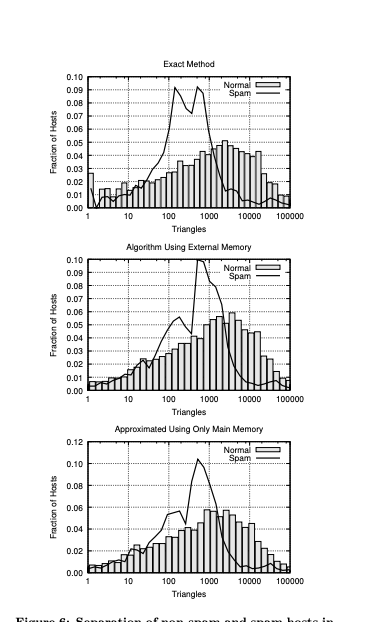
* Also clustering coefficients in social networks: https://cs.stanford.edu/~rishig/courses/ref/l1.pdf

Solution 1: Enumerate explicitly over all triples and check which are triangles, using the adjacency matrix

In [18]:
let mut count: u32 = 0;
let mut coefficients: Vec<u32> = vec![0;n];
for u in 0..n {
    for v in u+1..n {
        for w in v+1..n {
            if (graph_matrix[u][v] && graph_matrix[v][w] && graph_matrix[u][w]) {
                count += 1;
                coefficients[u] += 1;
                coefficients[v] += 1;
                coefficients[w] += 1;
            }
        }
    }
}
println!("{}", count);
println!("{:?}", coefficients);

2
[2, 1, 2, 1, 0, 0]


### Complexity of the algorithm above $O(n^3)$

## Count triangles

**Problem to solve:** Consider all triples of vertices. What is the number of those in which all vertices are connected?

**Solution 2:** Follow links from each vertex to see if you come back in three steps

In [19]:
let mut count: u32 = 0;
for u in 0..n {
    for v in &graph_list[u] {
        for w in &graph_list[*v] {
            for u2 in &graph_list[*w] {
                if u == *u2 {
                    count += 1;
                    break;
                }
            }
        }
    }
}
count

12

In [9]:
// need to divide by 6
// due to symmetries triangles counted multiple times
count / 6

2

### Complexity of the algorithm above $O(n^4)$ if everyone connected to everyone else but if degree is low then this is $O(n*m)$
### Why didn't we need the division in the matrix version of the algorithm?

## Count triangles

**Problem to solve:** Consider all triples of vertices. What is the number of those in which all vertices are connected?

Different implementation of solution 2

In [10]:
fn walk(current:usize,destination:usize,steps:usize,adjacency_list:&Vec<Vec<usize>>) -> u32 {
    match steps {
        0 => if current == destination {1} else {0},
        _ => {
            let mut count = 0;
            for v in &adjacency_list[current] {
                count += walk(*v,destination,steps-1,adjacency_list);
            }
            count
        }
    }
}

In [11]:
let mut count = 0;
for v in 0..n {
    count += walk(v,v,3,&graph_list);
}
count / 6

2

## Count triangles

**Problem to solve:** Consider all triples of vertices. What is the number of those in which all vertices are connected?

**Solution 3:** For each vertex try all pairs of neighbors (via adjacency lists) and see if they are connected (via adjacency matrix)

In [12]:
let mut count: u32 = 0;
for u in 0..n {
    let neighbors = &graph_list[u];
    for v in neighbors {
        for w in neighbors {
            if graph_matrix[*v][*w] {
                count += 1;
            }
        }
    }
}
count / 6

2

# 1. Representing graphs: examples in Rust
# 2. Sample graph algorithms
# <font color="red">3. Modules</font>

## Modules

Up to now: **our** functions and data types (mostly) in the same namespace<br>
&nbsp;&nbsp;&nbsp;$\bullet$ **exception:** functions in structs and enums

One can create a namespace, using `mod`

In [15]:
mod things_to_say {
    fn say_hi() {
        say("Hi");
    }
    
    fn say_bye() {
        say("Bye");
    }
    
    fn say(what: &str) {
        println!("{}!",what);
    }
}

You have to use the module name to refer to access a function.

In [16]:
things_to_say::say_hi();

Error: function `say_hi` is private

## Modules

* By default, all definitions in the namespace are private.
* Advantage: Can hide all internally used code
* Use `pub` to make functions or types public

In [17]:
mod things_to_say {
    pub fn say_hi() {
        say("Hi");
    }
    
    pub fn say_bye() {
        say("Bye");
    }
    
    fn say(what: &str) {
        println!("{}!",what);
    }
}

In [18]:
things_to_say::say_hi();

Hi!


### Why modules?

* limit number of additional identifiers in the main namespace

* organize your codebase into meaningful parts

* hide auxiliary internal code


* By default, all definitions in the namespace are private.
* Advantage: one can hide all internally used code
* Use `pub` to make functions or types public

## Nesting possible

In [20]:
mod level_1 {

    mod level_2_1 {

        mod level_3 {

            pub fn where_am_i() {println!("3");}

        }

        pub fn where_am_i() {println!("2_1");}
        
    }
    
    mod level_2_2 {
        
        pub fn where_am_i() {println!("2_2");}
        
    }
    
    pub fn where_am_i() {println!("1");}
    
}

In [21]:
level_1::level_2_1::level_3::where_am_i();




















Error: module `level_2_1` is private

In [22]:
mod level_1 {

    pub mod level_2_1 {

        pub mod level_3 {

            pub fn where_am_i() {println!("3");}

        }

        pub fn where_am_i() {println!("2_1");}
        
    }
    
    pub mod level_2_2 {
        
        pub fn where_am_i() {println!("2_2");}
        
    }
    
    pub fn where_am_i() {println!("1");}
    
}

In [23]:
level_1::level_2_1::level_3::where_am_i();

3


### Read chapter 7 from the Rust book